In [1]:
import os
import time
import yaml

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from kornia.losses import ssim_loss

from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from Models.BrownianBridgeModel.UNet import UNetModel
# from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet

from generative.networks.schedulers.ddpm import DDPMScheduler

from utils import namespace2dict, dict2namespace, create_gif

In [2]:
def load_config(config_path):
    with open(config_path, 'r') as f:
        dict_config = yaml.load(f, Loader=yaml.FullLoader)
    n_config = dict2namespace(dict_config)
    
    if n_config.model.test_unet_exclusive:
        n_config.model.use_condition = False
        
    if n_config.model.use_condition:
        n_config.model.DDPM.UNetParams.in_channels = 2
    else:
        n_config.model.DDPM.UNetParams.in_channels = 1
    
    return n_config, namespace2dict(n_config) 

def load_unet_model(run, epoch = 0):
    results_path = "/home/s1736191/myjupyter/DiffusionMAR/Results"
    run = str(run)
    results_path = os.path.join(results_path, run)

    config_file = "config.yaml"
    config_path = os.path.join(results_path, config_file)

    n_config, _ = load_config(config_path)

    unet_config = n_config.model.DDPM.UNetParams
    #epochs = n_config.trainingparams.epochs
    test_unet_exclusive = n_config.model.test_unet_exclusive
    use_condition = n_config.model.use_condition
    loss_type = n_config.model.DDPM.params.loss_type
    
    DEVICE = torch.device('cpu')
    
    checkpoints_folder = "Checkpoints"
    checkpoints_path = os.path.join(results_path, checkpoints_folder)
    for epoch_file in os.listdir(checkpoints_path):
        if '_' + str(epoch-1) + '.' in epoch_file:
            last_epoch_file = epoch_file
            break
    
    # Load unet model
    model = UNetModel(**vars(unet_config)).to(device=DEVICE)
    
    model.load_state_dict(torch.load(os.path.join(checkpoints_path, last_epoch_file), map_location=DEVICE)['state_dict'])
    model.eval()
    return model

def get_mean_per_pixel(img_array):    
    mean_per_pixel = np.zeros_like(img_array[0])
    for img in img_array:
        mean_per_pixel += img
    return mean_per_pixel/len(img_array)

def get_var_per_pixel(img_array, mean_per_pixel):
    var_per_pixel = np.zeros_like(img_array[0])
    for img in img_array:
        img = img - mean_per_pixel
        img = img ** (2)
        var_per_pixel += img
    return var_per_pixel/len(img_array)

def get_inp_tar(path):
    return np.load(os.path.join(path, 'input.npy')), np.load(os.path.join(path, 'target.npy'))

def get_chains(path):
    chains_diffusion = []
    chains_onestep = []
    for item in os.listdir(path):
        if 'diffusion' in item:
            chains_diffusion.append(np.load(os.path.join(path, item)))
        elif 'onestep' in item:
            chains_onestep.append(np.load(os.path.join(path, item)))
    return chains_diffusion, chains_onestep

def get_predictions(path):
    predictions = []
    for item in os.listdir(path):
        if 'prediction' in item:
            predictions.append(np.load(os.path.join(path, item)))
    return predictions

def get_results(path):
    chains_diffusion = []
    chains_onestep = []
    predictions = []
    for item in os.listdir(path):
        if 'diffusion' in item:
            chains_diffusion.append(np.load(os.path.join(path, item)))
        elif 'onestep' in item:
            chains_onestep.append(np.load(os.path.join(path, item)))
        elif 'prediction' in item:
            predictions.append(np.load(os.path.join(path, item)))
    return chains_diffusion, chains_onestep, predictions

def split_chain(chain):
    array = []
    shape = np.shape(chain)
    img_size = shape[2]
    steps = int(shape[3] / img_size)
    for img_i in range(steps):
        array.append(chain[0, 0, :, 256*(img_i): 256*(img_i+1)])
    return array

def combine_to_single_img(samples, nrows=1):
    ncols = len(samples)//nrows
    if len(samples) > nrows*ncols:
        ncols += 1 
    for row in range(nrows):
        for col in range(ncols):
            if col==0:
                outrow = samples[row*ncols + col]
                continue
            if len(samples)-1 < row*ncols + col:
                outrow = torch.cat((outrow, torch.zeros_like(samples[0])), dim=1)
            else:
                outrow = torch.cat((outrow, samples[row*ncols + col]), dim=1)
        if row==0:
            out = outrow
        else:
            out = torch.cat((out, outrow), dim=0)
    return out

def toHU(sample):
    return sample * 2000 + 1000

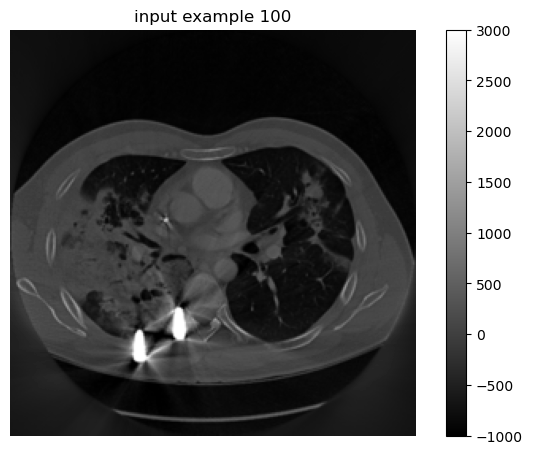

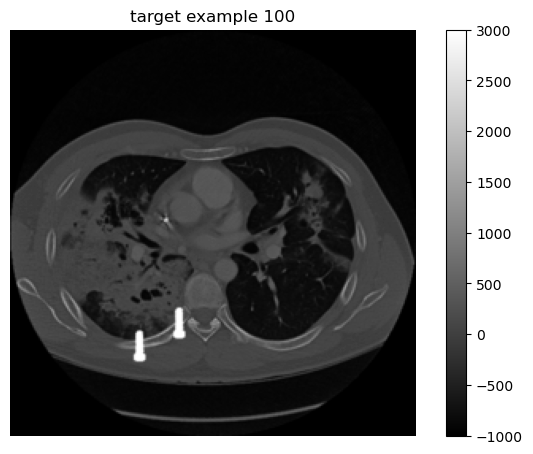

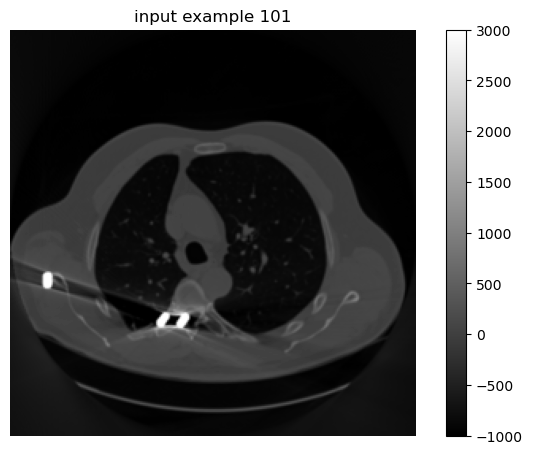

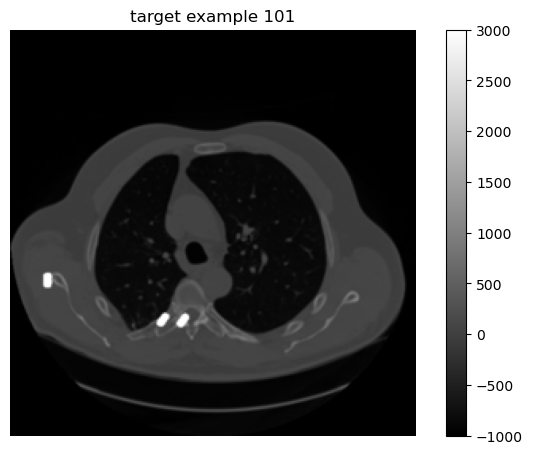

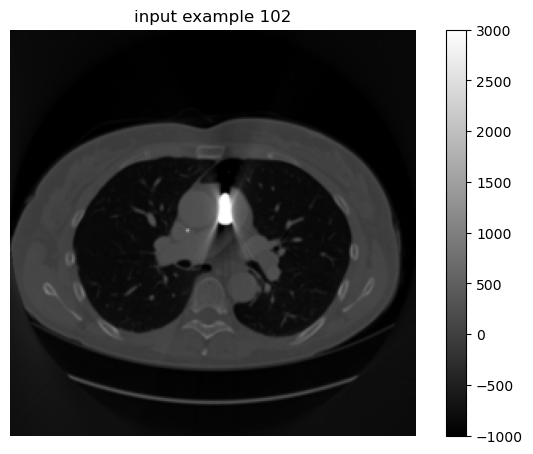

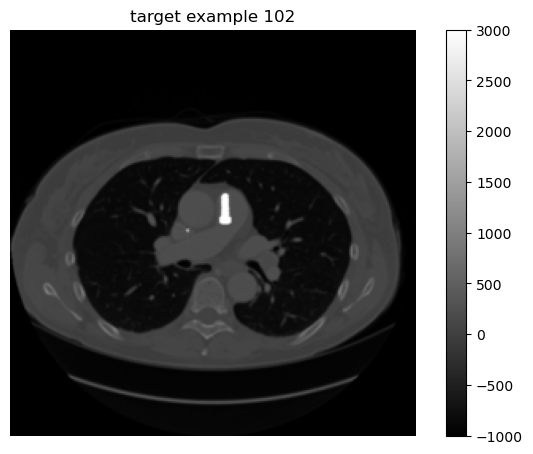

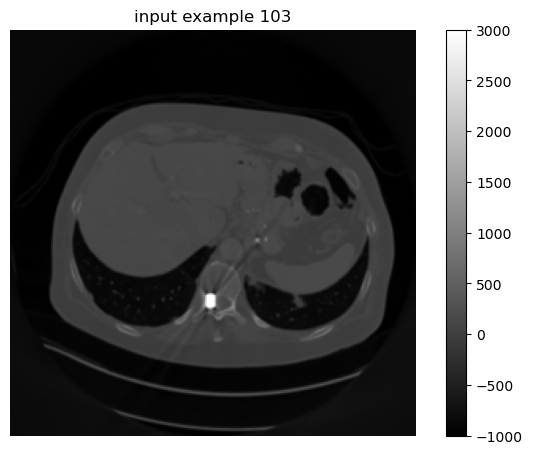

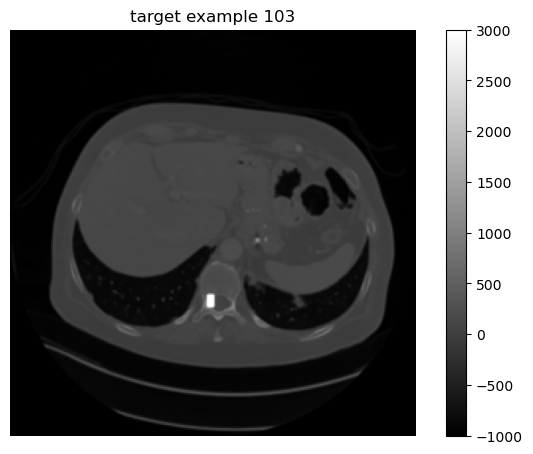

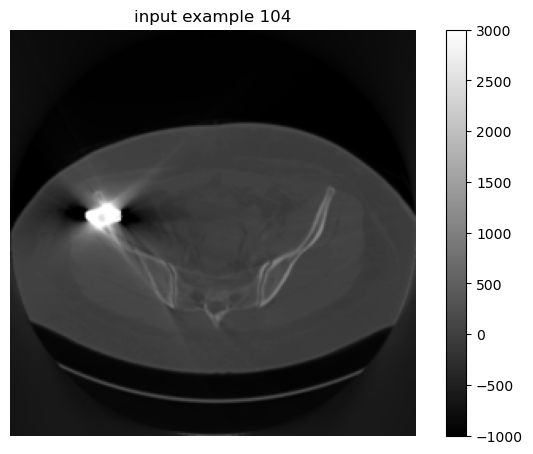

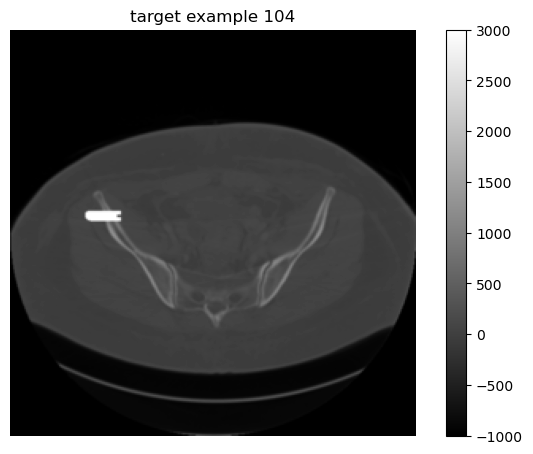

In [3]:
path = '/home/s1736191/myjupyter/DiffusionMAR/eval_images/'
models = ['DDPM_lin-example_',
          'DDPM10p-example_',
          'DDPM1p-example_'         
         ]

n_examples = 5

inps_tars = []

full_paths = [[],[],[]]
for i, model in enumerate(models):
    for example_i in range(n_examples):
        full_paths[i].append(os.path.join(path, model + str(100 + example_i)))
        if i > 0:
            continue
        inp, tar = get_inp_tar(full_paths[i][-1])
        inps_tars.append([inp, tar])

        plt.figure()
        plt.title('input example ' + str(100 + example_i))
        plt.imshow(toHU(inp), cmap='gray')
        plt.colorbar()
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        plt.figure()
        plt.title('target example ' + str(100 + example_i))
        plt.imshow(toHU(tar), cmap='gray')
        plt.colorbar()
        plt.tight_layout()
        plt.axis("off")
        plt.show()  

In [4]:
UNET100 = load_unet_model('UNET', 12)
UNET10 = load_unet_model('UNET10p', 75)
UNET1 = load_unet_model('UNET1p', 150)
UNETS = [UNET100, UNET10, UNET1]

unet_preds = []
for inp, tar in inps_tars:
    unet_inp = torch.Tensor(inp)
    unet_inp = unet_inp.unsqueeze(0).unsqueeze(0)
    prds = []
    for UNET in UNETS:
        prds.append(UNET(unet_inp, timesteps=torch.Tensor((1,))))
    unet_preds.append(prds)

In [39]:
ex_i = 4
unet_ex_preds = unet_preds[ex_i]

prediction 100% 0
ssim loss: 0.005272925365716219


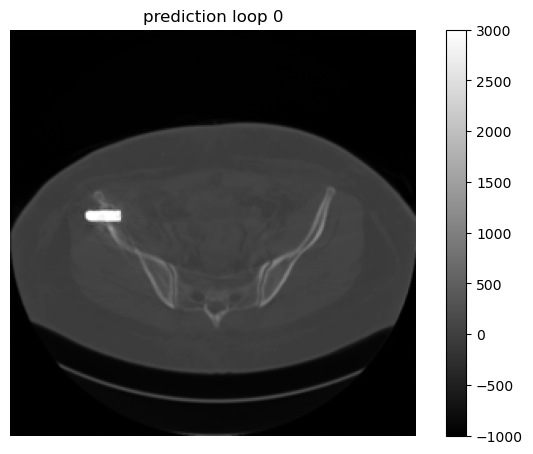

prediction 100% 1
ssim loss: 0.004842750728130341


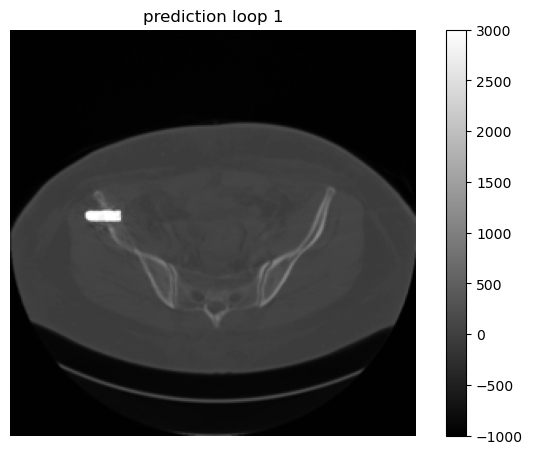

prediction 100% 2
ssim loss: 0.005370856262743473


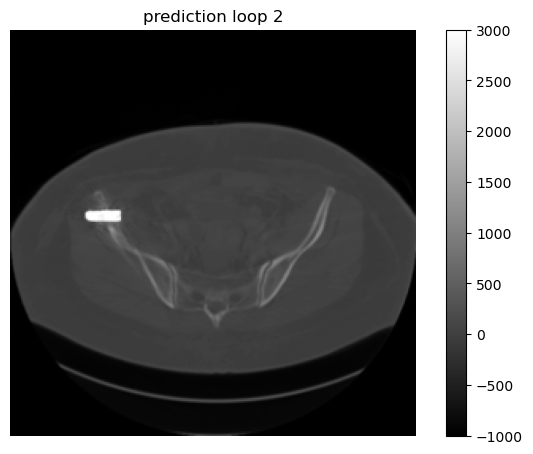

prediction 100% 3
ssim loss: 0.005332408472895622


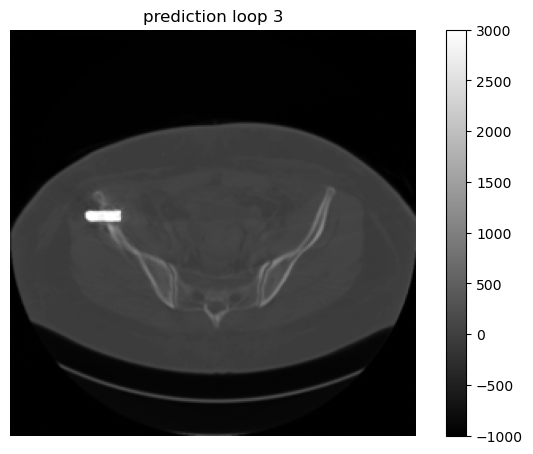

prediction 100% 4
ssim loss: 0.004862949717789888


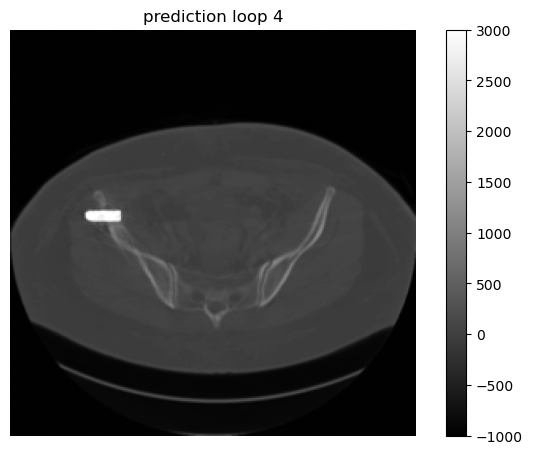

prediction 100% 5
ssim loss: 0.004986003041267395


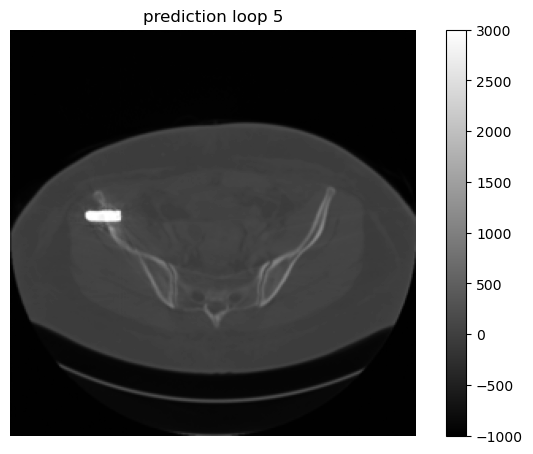

prediction 100% 6
ssim loss: 0.005174726247787476


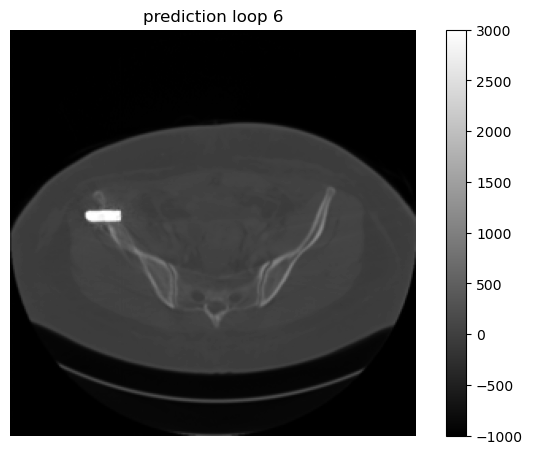

prediction 100% 7
ssim loss: 0.004936241544783115


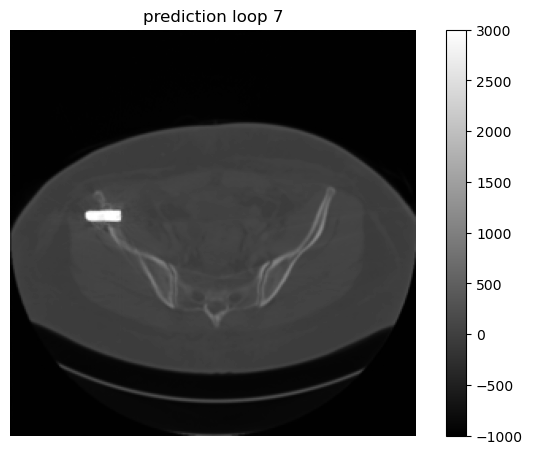

prediction 100% 8
ssim loss: 0.0052685607224702835


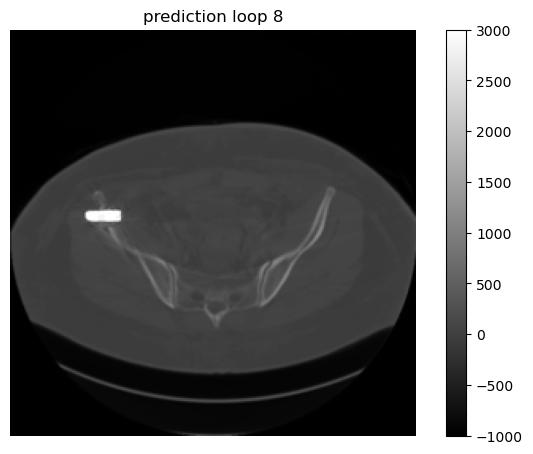

prediction 100% 9
ssim loss: 0.00554822850972414


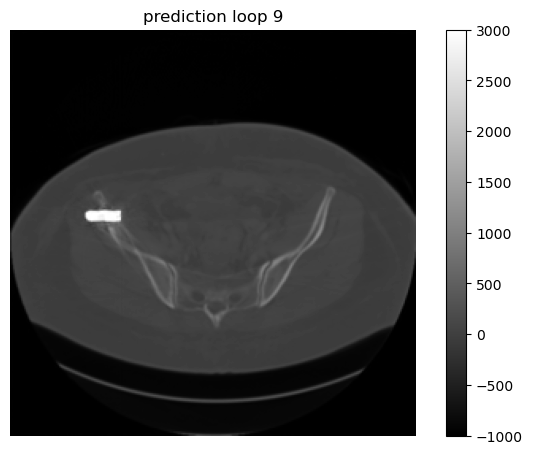

prediction 10% 0
ssim loss: 0.00761647243052721


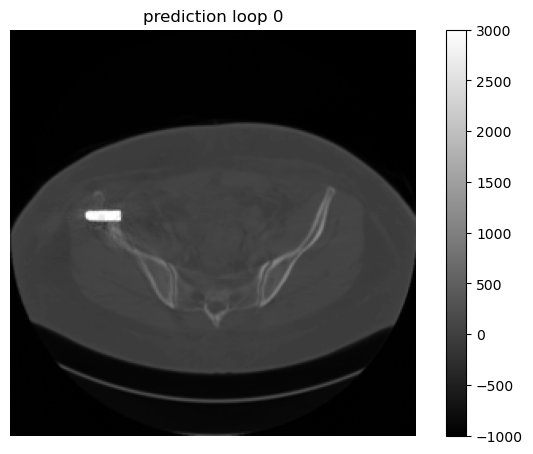

prediction 10% 1
ssim loss: 0.0075266920030117035


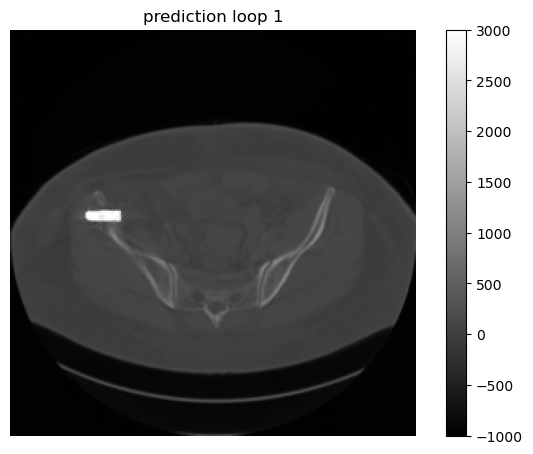

prediction 10% 2
ssim loss: 0.007810153998434544


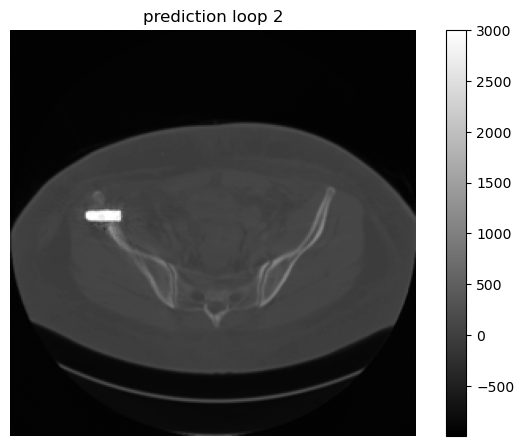

prediction 10% 3
ssim loss: 0.006659660488367081


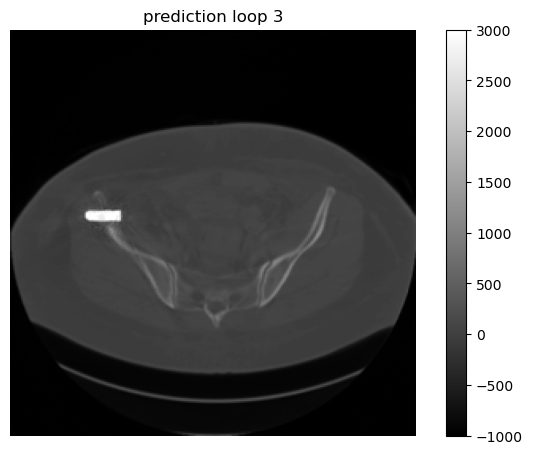

prediction 10% 4
ssim loss: 0.006808301899582148


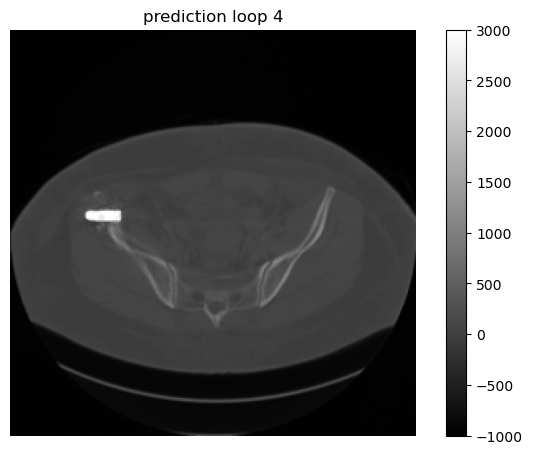

prediction 10% 5
ssim loss: 0.007070321589708328


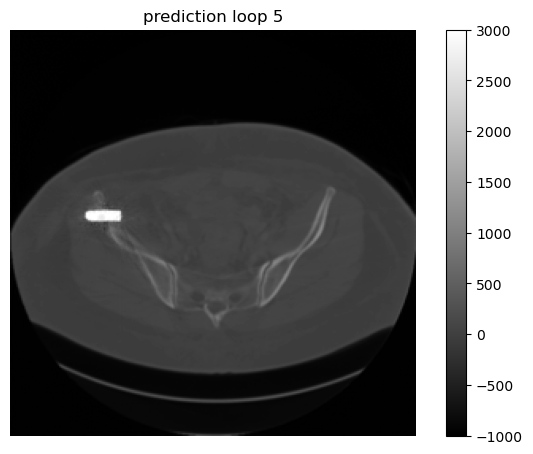

prediction 10% 6
ssim loss: 0.007567189168184996


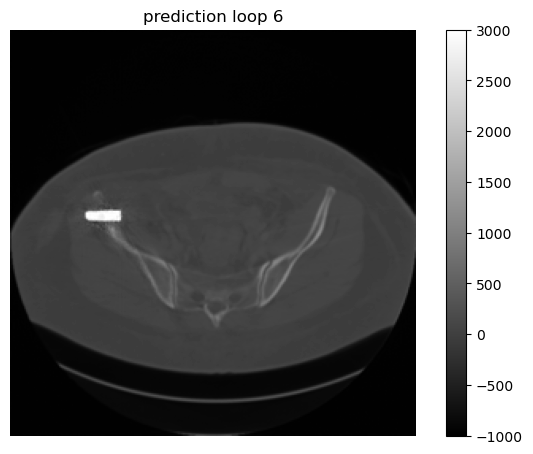

prediction 10% 7
ssim loss: 0.007521144114434719


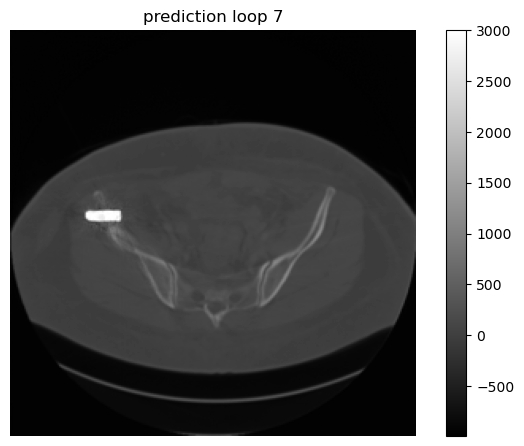

prediction 10% 8
ssim loss: 0.006871461868286133


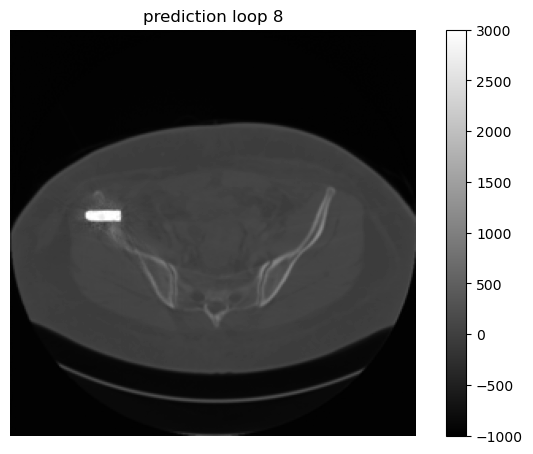

prediction 10% 9
ssim loss: 0.007110239937901497


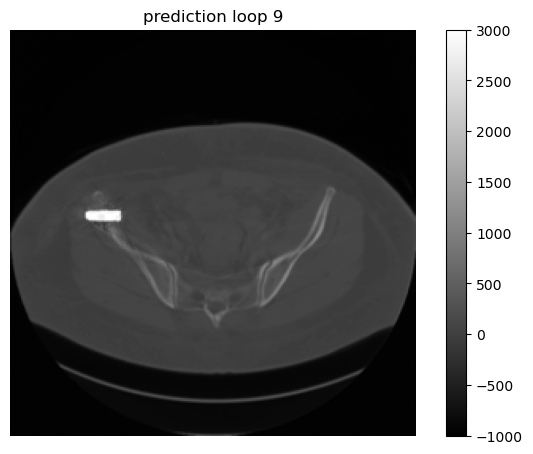

prediction 1% 0
ssim loss: 0.21130456030368805


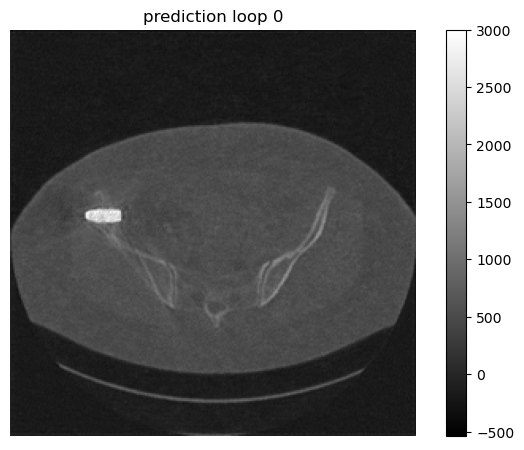

prediction 1% 1
ssim loss: 0.116410031914711


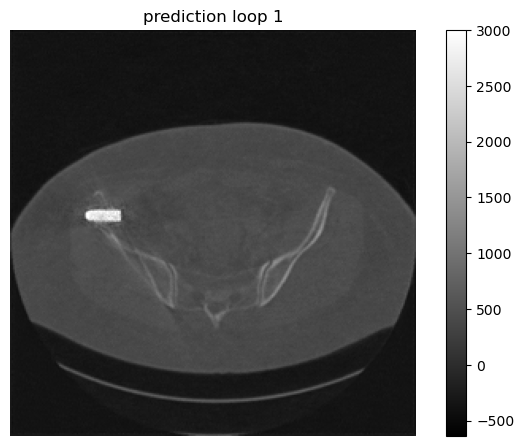

prediction 1% 2
ssim loss: 0.4617966413497925


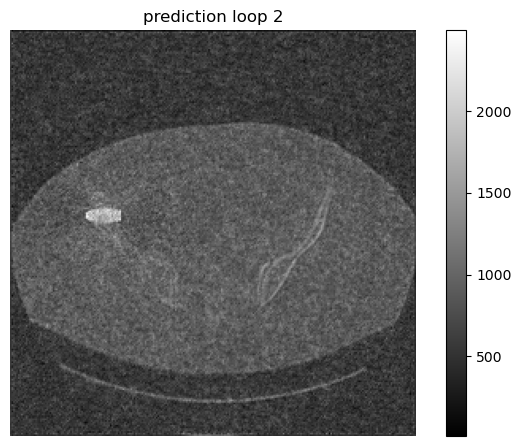

prediction 1% 3
ssim loss: 0.014796480536460876


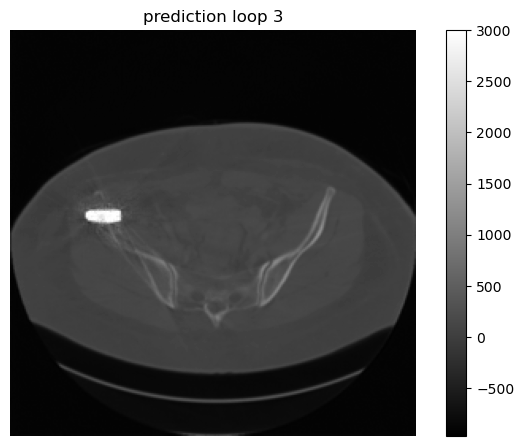

prediction 1% 4
ssim loss: 0.25298911333084106


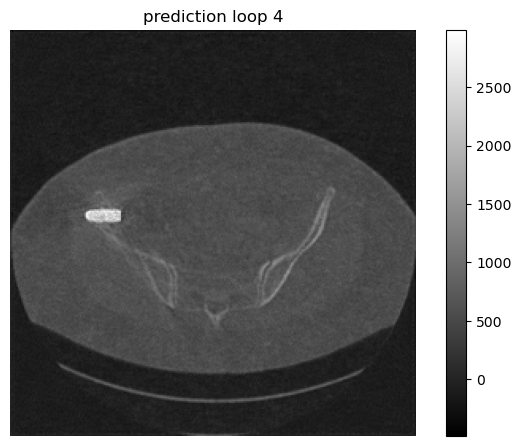

prediction 1% 5
ssim loss: 0.46082547307014465


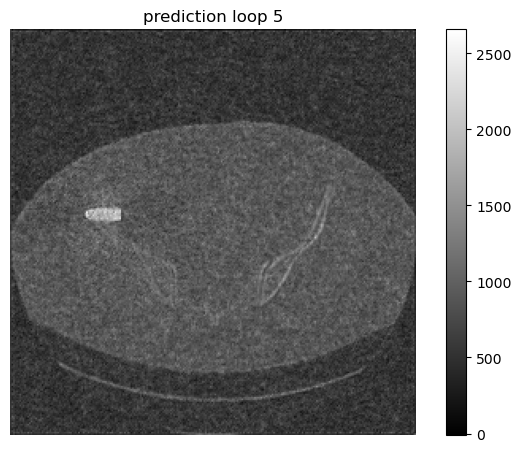

prediction 1% 6
ssim loss: 0.5291496515274048


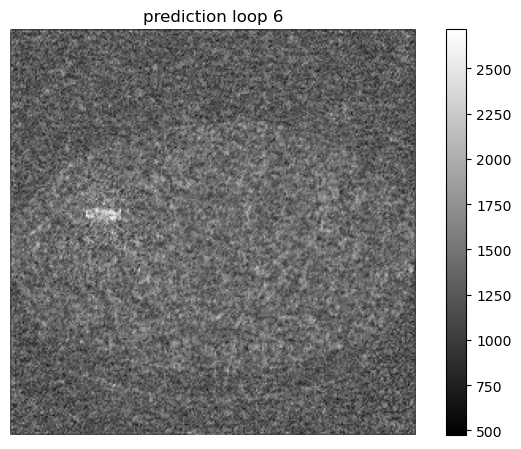

prediction 1% 7
ssim loss: 0.3100460171699524


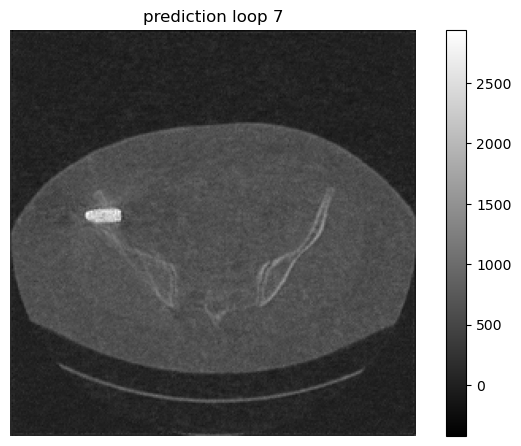

prediction 1% 8
ssim loss: 0.11687415093183517


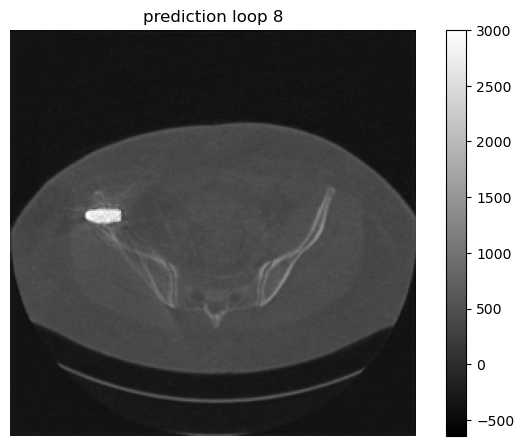

prediction 1% 9
ssim loss: 0.014281898736953735


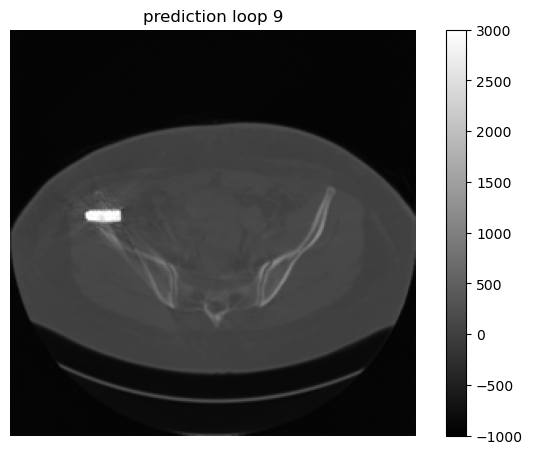

In [40]:
predictions100 = get_predictions(full_paths[0][ex_i])
predictions10 = get_predictions(full_paths[1][ex_i])
predictions1 = get_predictions(full_paths[2][ex_i]) 

inp, tar = get_inp_tar(full_paths[0][ex_i])

for i, prediction in enumerate(predictions100):
    print('prediction 100% ' + str(i))
    ssimloss = ssim_loss(torch.Tensor(prediction).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
    print('ssim loss:', ssimloss.item())
    
    plt.figure()
    plt.title('prediction loop ' + str(i))
    plt.imshow(toHU(prediction), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    
for i, prediction in enumerate(predictions10):
    print('prediction 10% ' + str(i))
    ssimloss = ssim_loss(torch.Tensor(prediction).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
    print('ssim loss:', ssimloss.item())
    
    plt.figure()
    plt.title('prediction loop ' + str(i))
    plt.imshow(toHU(prediction), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()

for i, prediction in enumerate(predictions1):
    print('prediction 1% ' + str(i))
    ssimloss = ssim_loss(torch.Tensor(prediction).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
    print('ssim loss:', ssimloss.item())
    
    plt.figure()
    plt.title('prediction loop ' + str(i))
    plt.imshow(toHU(prediction), cmap='gray')
    plt.colorbar()
    plt.tight_layout()
    plt.axis("off")
    plt.show()

100%
ssim loss: 0.003978936932981014


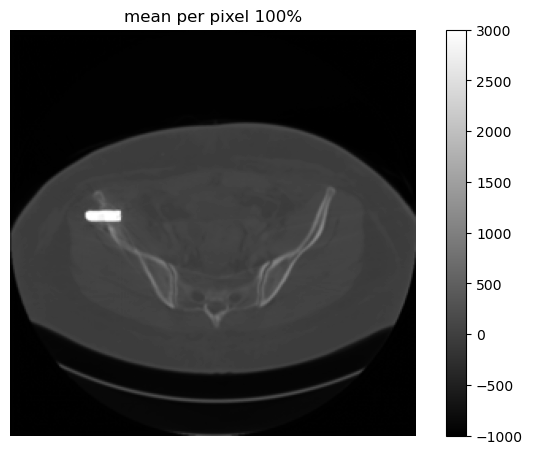

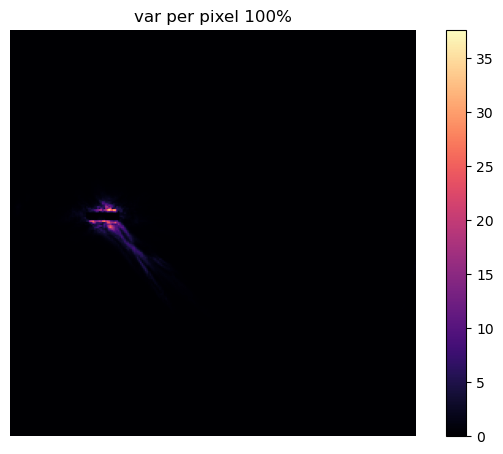

10%
ssim loss: 0.005261988379061222


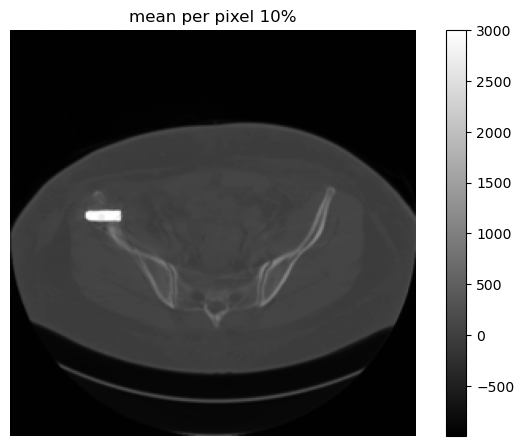

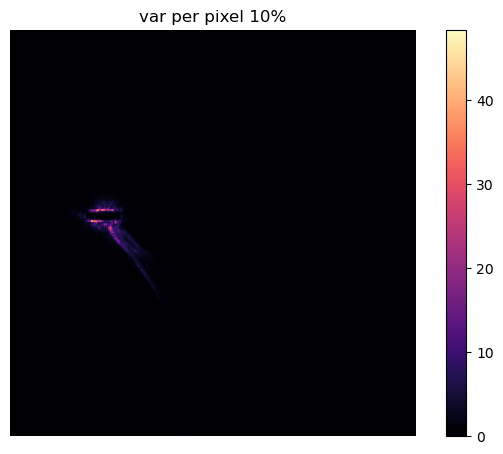

1%
ssim loss: 0.1910310685634613


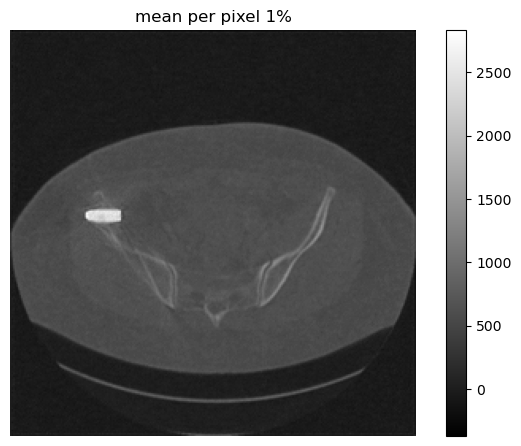

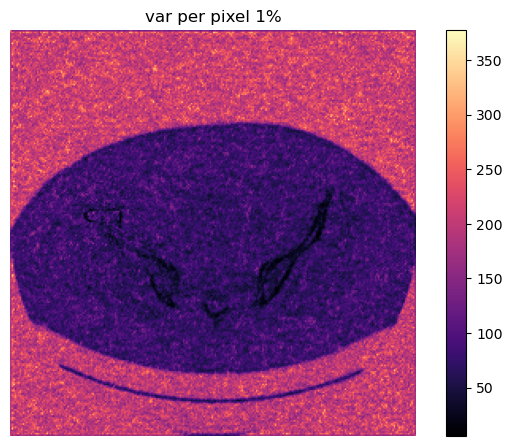

In [41]:
mean_per_pixel100 = get_mean_per_pixel(predictions100)
var_per_pixel100 = get_var_per_pixel(predictions100, mean_per_pixel100)

mean_per_pixel10 = get_mean_per_pixel(predictions10)
var_per_pixel10 = get_var_per_pixel(predictions10, mean_per_pixel10)

mean_per_pixel1 = get_mean_per_pixel(predictions1)
var_per_pixel1 = get_var_per_pixel(predictions1, mean_per_pixel1)

ddpm_ex_preds = [mean_per_pixel100, mean_per_pixel10, mean_per_pixel1]

print('100%')
ssimloss = ssim_loss(torch.Tensor(mean_per_pixel100).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
print('ssim loss:', ssimloss.item())

plt.figure()
plt.title('mean per pixel 100%')
plt.imshow(toHU(mean_per_pixel100), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('var per pixel 100%')
plt.imshow(2000 * var_per_pixel100, cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

print('10%')
ssimloss = ssim_loss(torch.Tensor(mean_per_pixel10).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
print('ssim loss:', ssimloss.item())

plt.figure()
plt.title('mean per pixel 10%')
plt.imshow(toHU(mean_per_pixel10), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('var per pixel 10%')
plt.imshow(2000 * var_per_pixel10, cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

print('1%')
ssimloss = ssim_loss(torch.Tensor(mean_per_pixel1).unsqueeze(dim=0).unsqueeze(dim=0), torch.Tensor(tar).unsqueeze(dim=0).unsqueeze(dim=0), 11)
print('ssim loss:', ssimloss.item())

plt.figure()
plt.title('mean per pixel 1%')
plt.imshow(toHU(mean_per_pixel1), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure()
plt.title('var per pixel 1%')
plt.imshow(2000 * var_per_pixel1, cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.axis("off")
plt.show()

In [42]:
# unet_ex_preds, ddpm_ex_preds 

tars = combine_to_single_img([torch.Tensor(tar), torch.Tensor(tar), torch.Tensor(tar), 
                              torch.Tensor(tar), torch.Tensor(tar)], nrows=2)
prds = combine_to_single_img([torch.Tensor(unet_ex_preds[0]).squeeze(), torch.Tensor(unet_ex_preds[1]).squeeze(), 
                              torch.Tensor(unet_ex_preds[2]).squeeze(),
                              torch.Tensor(ddpm_ex_preds[0]).squeeze(), torch.Tensor(ddpm_ex_preds[1]).squeeze()], nrows=2)
diff = tars-prds                            

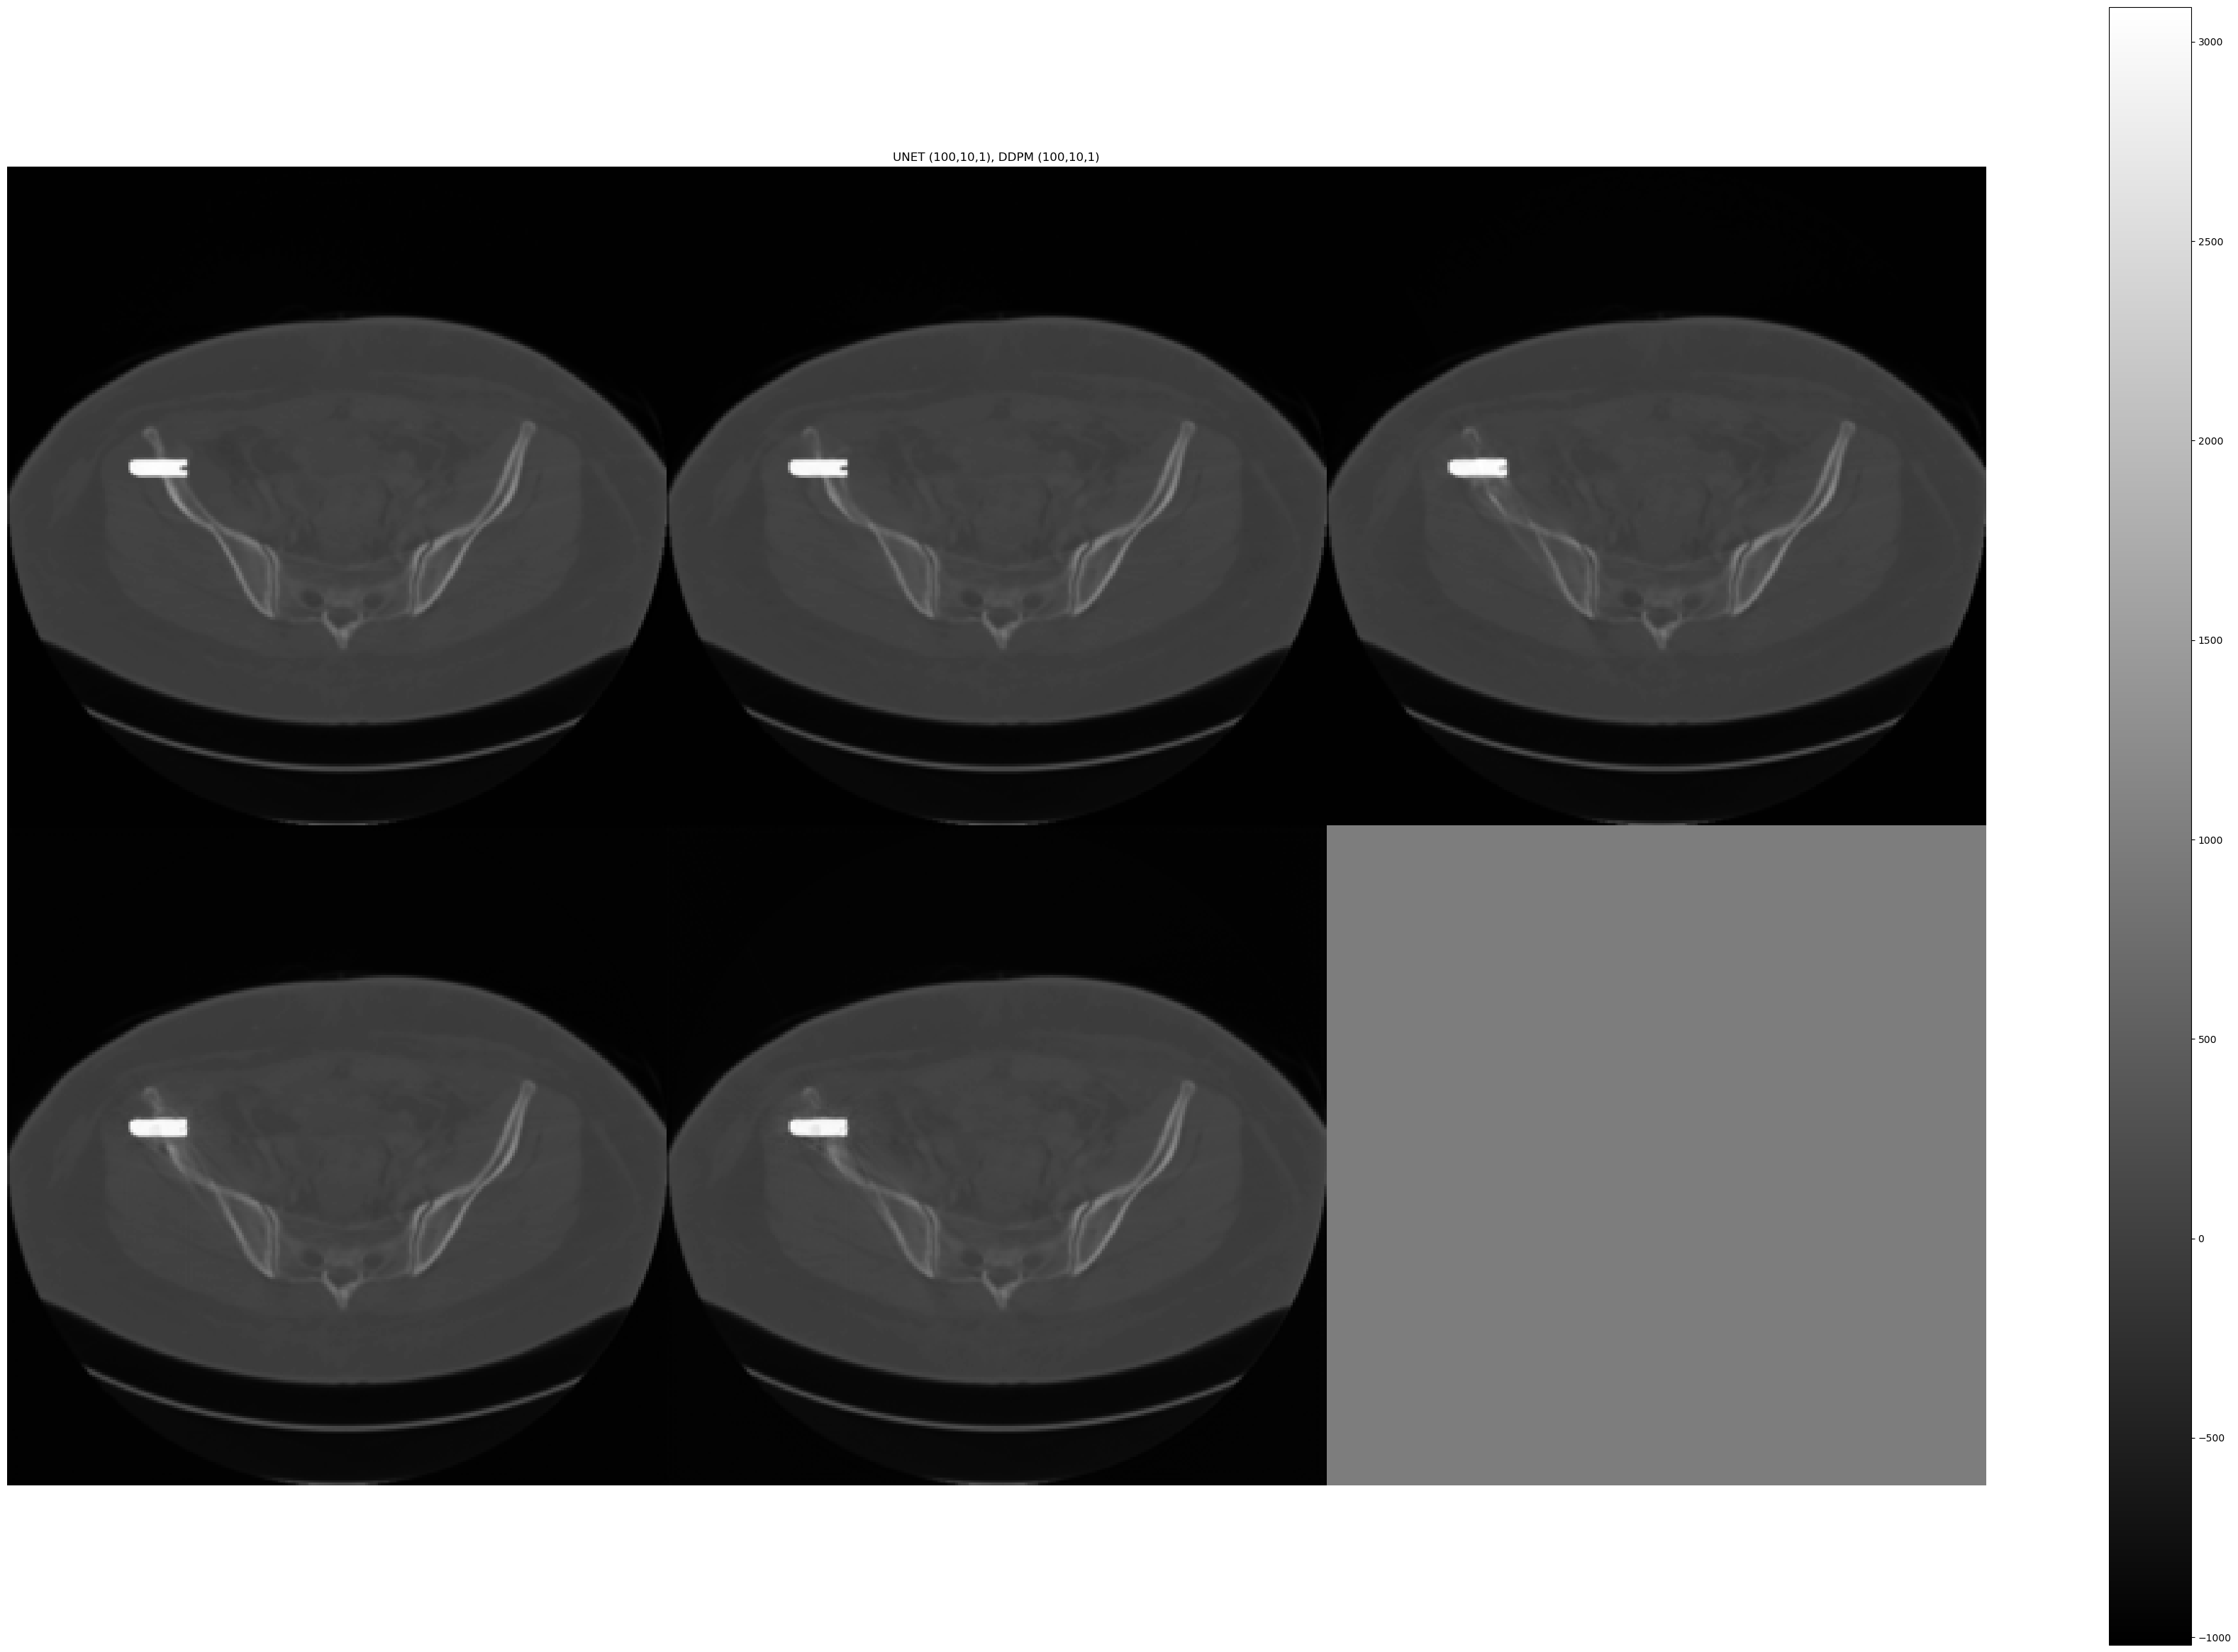

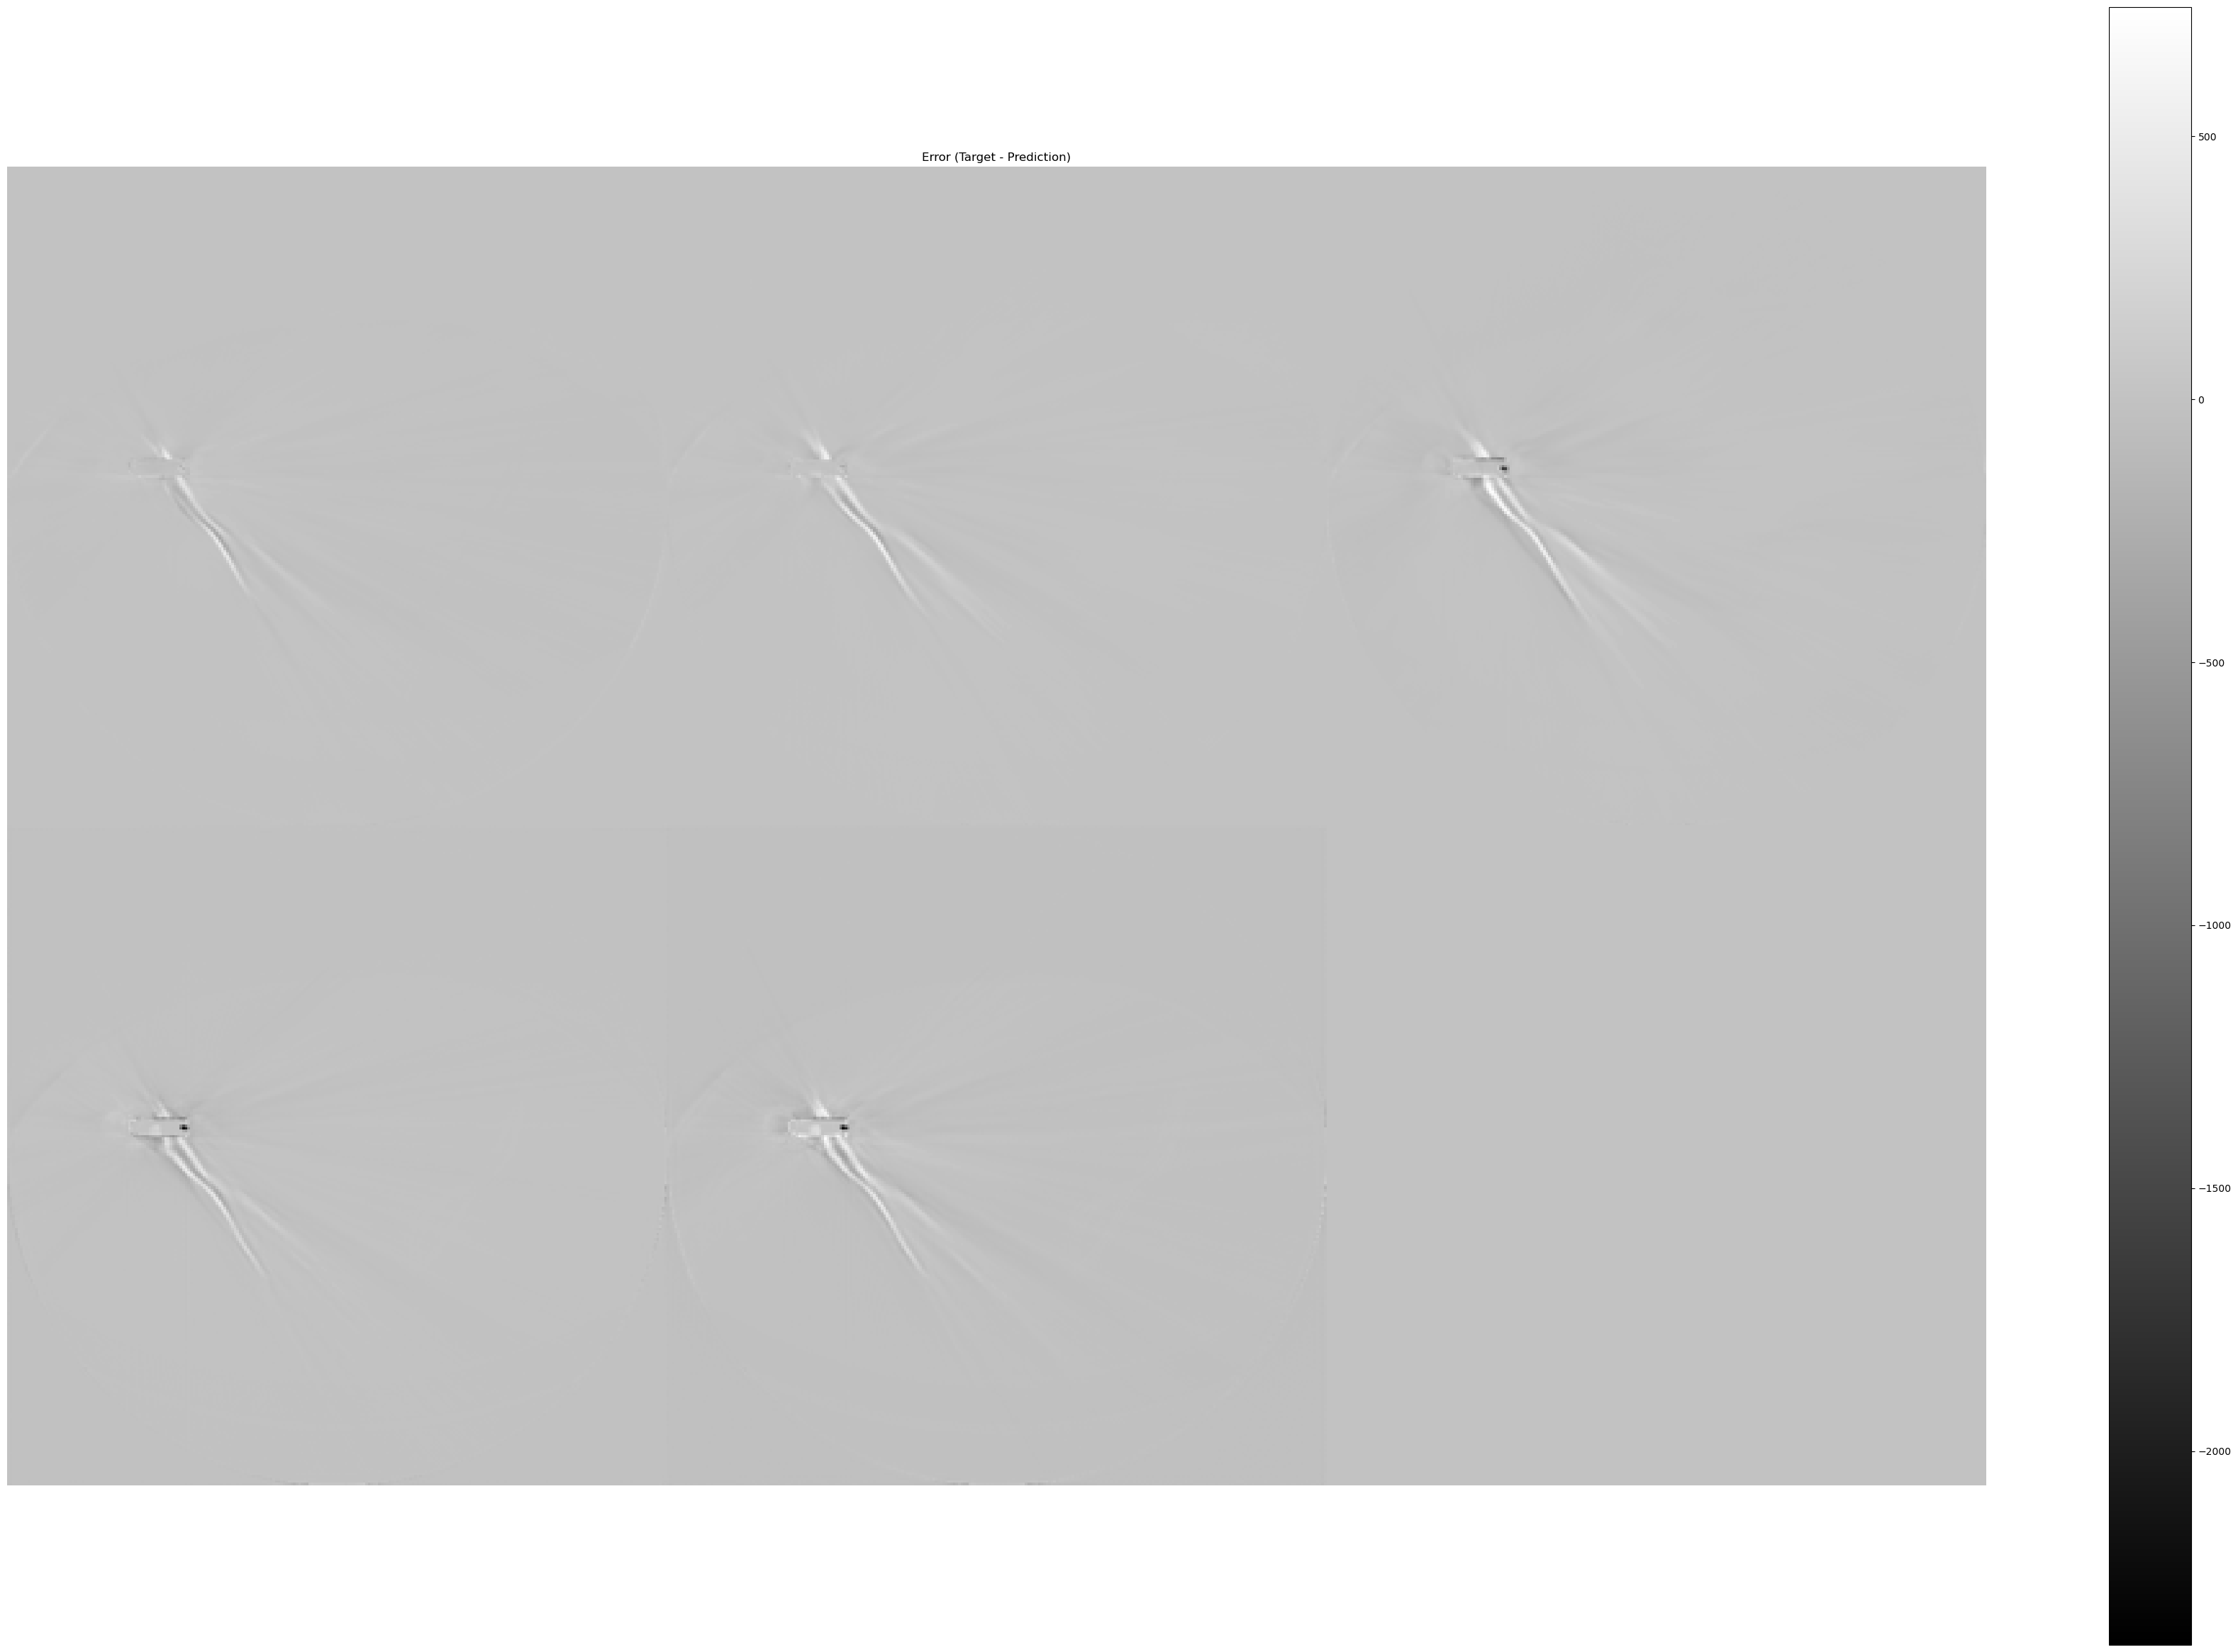

In [43]:
#plt.figure()
#plt.title('targets')
#plt.imshow(tars, cmap='gray')
#plt.show()

plt.figure(figsize=(45,30))
plt.title("UNET (100,10,1), DDPM (100,10,1)")
plt.imshow(toHU(prds.detach().numpy()), cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(45,30))
plt.title("Error (Target - Prediction)")
plt.imshow(2000 * diff.detach().numpy(), cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()